In [1]:
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

In [2]:
df_dir = 'dataset/'

In [3]:
def load_dataset(img_dir):
    p = Path(img_dir)
    dirs = p.glob('*')

    img_list = []

    for dir in dirs:
        label = dir.name
        for file in dir.glob('*.jpg'):
            img = mpimg.imread(file)

            if not img is None:
                img_list.append((img, label))
    
    return img_list

In [4]:
df = load_dataset(df_dir)

In [5]:
def img_viz(img_list, num_img):

    img = img_list[num_img][0]
    label = img_list[num_img][1]

    plt.imshow(img)
    print(f'Shape\t: {img.shape}')
    print(f'Label\t: {label}')

Shape	: (3456, 3456, 3)
Label	: Sayur Buah


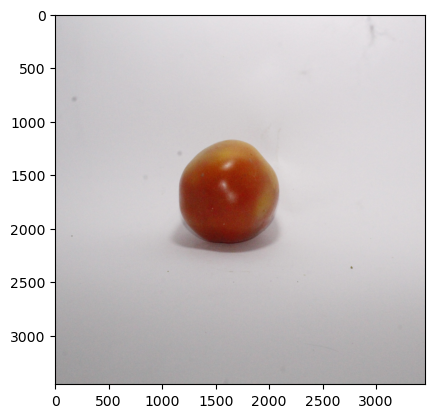

In [6]:
img_viz(df, 40)

In [7]:
def crop_center(img, ratio=0.8):
    h, w = img.shape[:2]
    ch, cw = int(h * ratio), int(w * ratio)
    y1 = (h - ch) // 2
    x1 = (w - cw) // 2
    return img[y1:y1+ch, x1:x1+cw]

In [8]:
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8,8))
    cl = clahe.apply(l)

    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

In [9]:
def segment_object(img):
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thr = cv2.adaptiveThreshold(
        grey, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        51, 5
    )
    kernel = np.ones((5,5), np.uint8)
    morph = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, kernel)
    return morph

In [10]:
def preprocessing_basic(img_list):
    result = []
    for img, label in img_list:
        
        cropped = crop_center(img)
        resized = cv2.resize(cropped, (224, 224))
        clahe = apply_clahe(resized)
        seg_mask = segment_object(clahe)   

        # final_img = clahe * (seg_mask > 0)

        result.append((clahe, label))
    
    return result


In [11]:
basic = preprocessing_basic(df)

Shape	: (224, 224, 3)
Label	: Sayur Buah


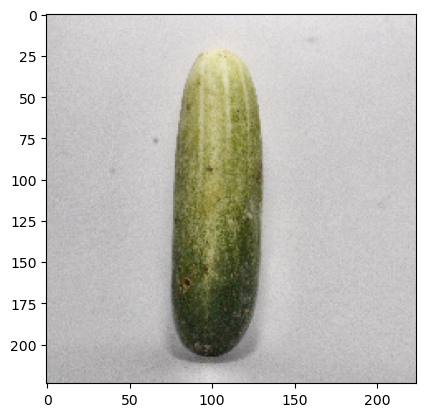

In [12]:
img_viz(basic, 60)

In [13]:
import random

def augment_img(img):
    # Flip horizontal
    if random.random() > 0.5:
        img = cv2.flip(img, 1)

    # Brightness variation
    if random.random() > 0.5:
        factor = 0.5 + random.random()
        img = cv2.convertScaleAbs(img, alpha=factor, beta=10)

    # Rotation small angle
    if random.random() > 0.5:
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), random.randint(-15,15), 1)
        img = cv2.warpAffine(img, M, (w, h))

    return img

In [14]:
def apply_augmentation(processed_list, n_aug=2):
    augmented = []

    for img, label in processed_list:
        augmented.append((img, label))  # original

        for _ in range(n_aug):
            aug = augment_img(img.copy())
            augmented.append((aug, label))

    return augmented

In [15]:
aug = apply_augmentation(basic, n_aug=3)

Shape	: (224, 224, 3)
Label	: Sayur Buah


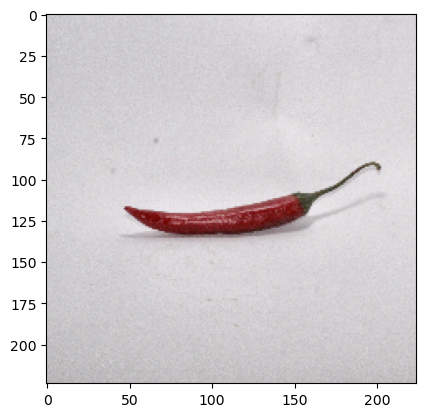

In [16]:
img_viz(aug, 185)

In [17]:
def preprocess_for_HOG(processed_list):
    result = []
    for img, label in processed_list:
        grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(grey, (3,3), 0)
        result.append((blurred, label))
    return result

In [18]:
hog_img = preprocess_for_HOG(aug)

Shape	: (224, 224)
Label	: Sayur Akar


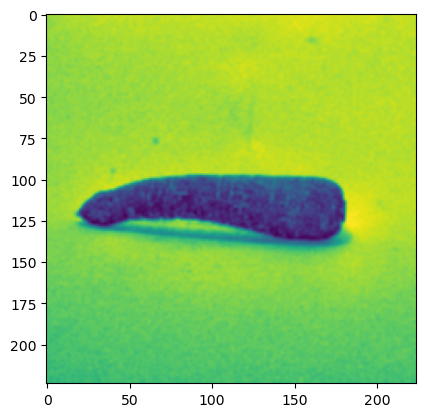

In [19]:
img_viz(hog_img, 100)

In [20]:
def preprocess_for_HSV(processed_list):
    result = []
    for img, label in processed_list:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        result.append((hsv, label))
    return result

In [21]:
hsv_img = preprocess_for_HSV(aug)

Shape	: (224, 224, 3)
Label	: Sayur Akar


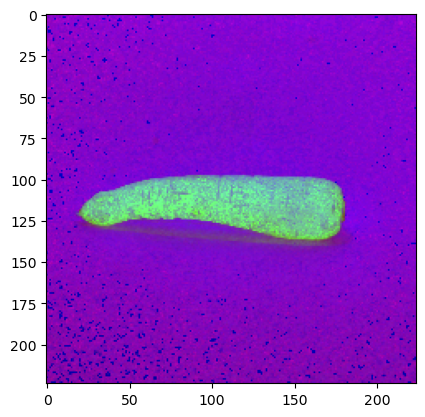

In [22]:
img_viz(hsv_img, 100)

In [23]:
def preprocess_for_GLCM(processed_list):
    result = []
    for img, label in processed_list:
        grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        result.append((grey, label))
    return result

In [24]:
glcm_img = preprocess_for_GLCM(aug)

Shape	: (224, 224)
Label	: Sayur Akar


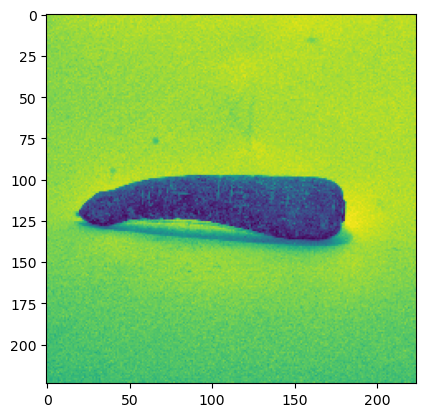

In [25]:
img_viz(glcm_img, 100)